# Using the rate to correct timestamp

Well here is another dead attempt to correct for the timestamp. This time we will use the aggregate data from the orbit buffer to bring back the pps. We will do a test drive on the veto pack

In [1]:
# Import libraries
import raadpy as rp
import matplotlib.pyplot as plt
import numpy as np

# Some constants
orbit_buffer_fname  = '../../Data/RAW/SD-915/Light1_2022-05-20_Buff1.dat'
veto_buffer_fname   = '../../Data/RAW/SD-915/Light1_2022-05-20_Buff6.dat'

%matplotlib ipympl

In [2]:
# Load the buffers
orbit   = rp.get_dict(orbit_buffer_fname,rp.ORBIT_STRUCT,condition="data['id_bit'] == 1")
veto    = rp.get_dict(veto_buffer_fname, rp.VETO_STRUCT,MAX=50000,STUPID=True)

Line:   0%|          | 0/4347 [00:00<?, ?it/s]

Line:   0%|          | 0/50000 [00:00<?, ?it/s]

(<Figure size 1500x400 with 1 Axes>,
 <AxesSubplot:title={'center':'Timestamps vs event number'}>)

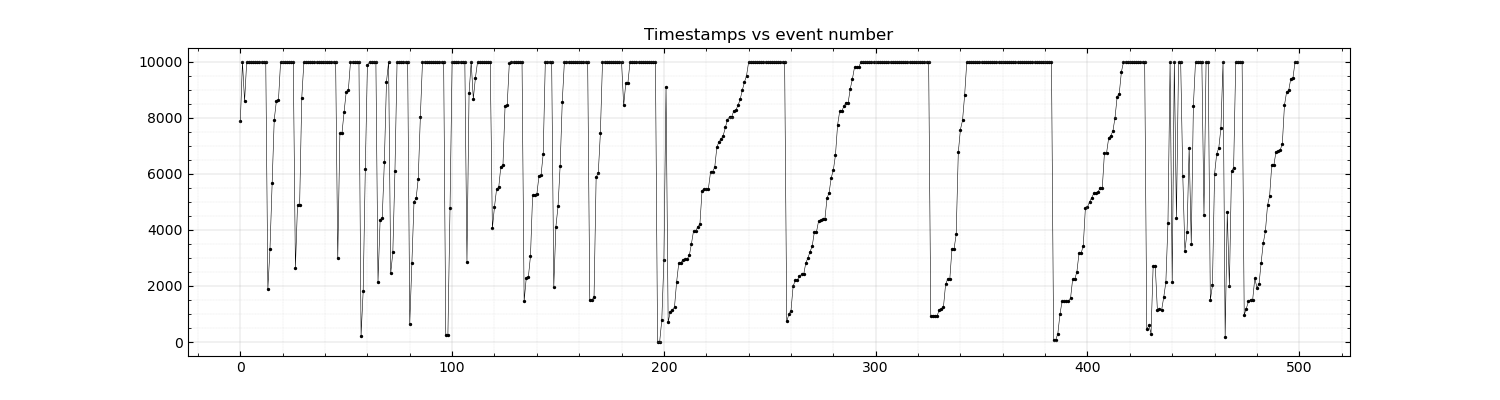

In [3]:
# Here is Some timestamps
rp.plot_timestamp(veto,rp.VETO_STRUCT,RANGE=(0,500))

Text(0.5, 0, 'seconds')

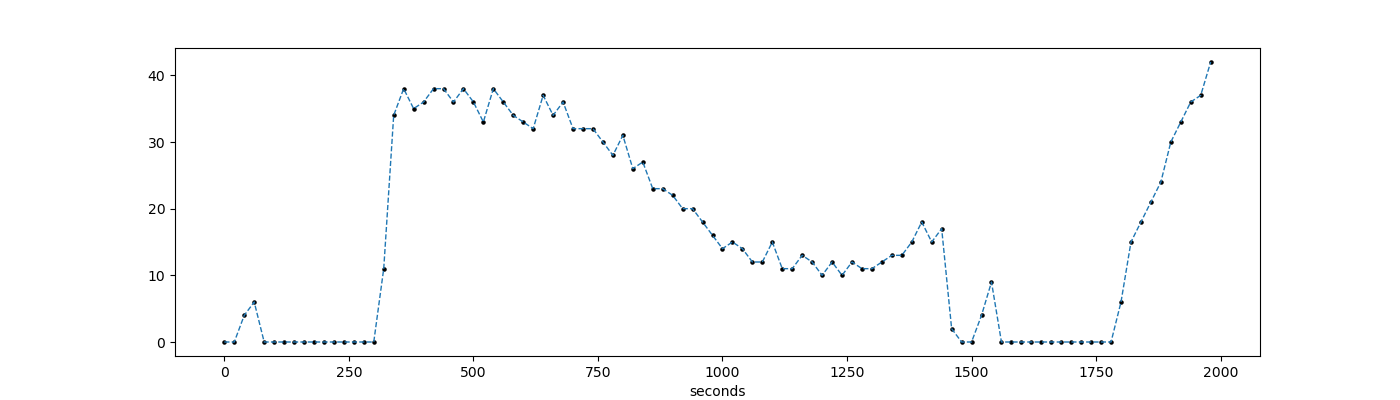

In [4]:
# Here are some rates

fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
x   = np.arange(100)*20
ax.plot(x,orbit['ratev'][:100],ls='--',lw=1)
ax.scatter(x,orbit['ratev'][:100],marker='o',s=5,c='k')
ax.set_xlabel('seconds')

Text(0.5, 0, 'seconds')

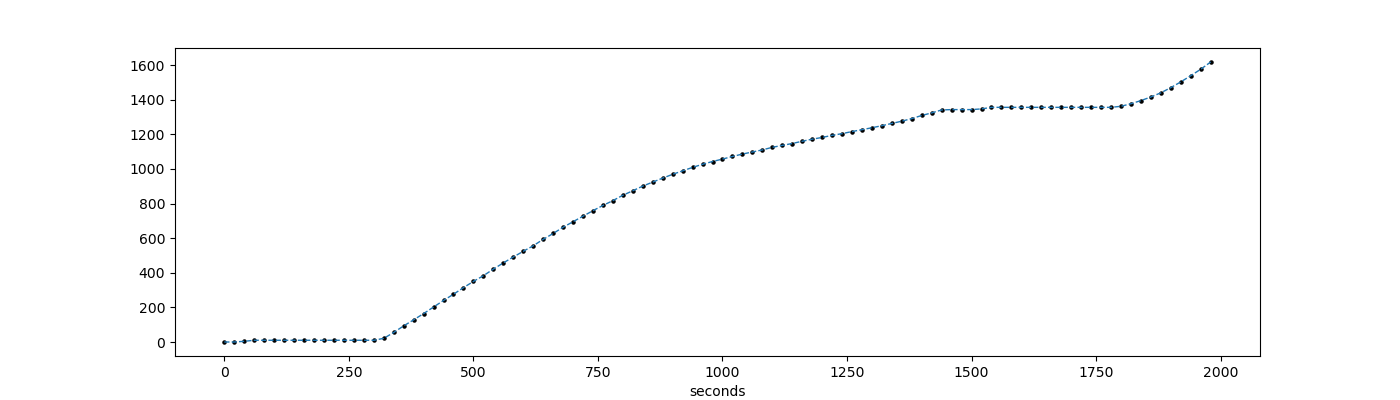

In [5]:
# Let's sum those rates
fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
x   = np.arange(100)*20
ax.plot(x,np.cumsum(orbit['ratev'][:100]),ls='--',lw=1)
ax.scatter(x,np.cumsum(orbit['ratev'][:100]),marker='o',s=5,c='k')
ax.set_xlabel('seconds')

In [6]:
# Now let's get some counts!

# Corrects the timestamp based on orbit rate
def correct_time_orbit(orbit:dict,TIME:int=20,RANGE=(0,100)):
    # Some variables
    total_cnt   = 0     # Stores the total number of events
    timestamp   = [0]   # New timestamp

    # For each count in the orbit
    for count in orbit['ratev'][RANGE[0]:RANGE[1]]:
        # Get the next number of counts
        count *= TIME
        if count == 0:
            timestamp[-1] += TIME
            continue

        # Linearly distribute the timestamps in between
        for item in np.linspace(timestamp[-1],timestamp[-1] + TIME,int(count)+1)[1:]: timestamp.append(item)
        total_cnt += count

    # remove the last element of the timestamp
    timestamp = timestamp[:-1]

    # Fix the total number of entries we have
    total_cnt = int(total_cnt)

    return timestamp, total_cnt

# Appy the function
TIME    = 20
RANGE   = (0,100)
timestamp,total_cnt = correct_time_orbit(orbit,TIME=TIME,RANGE=RANGE)

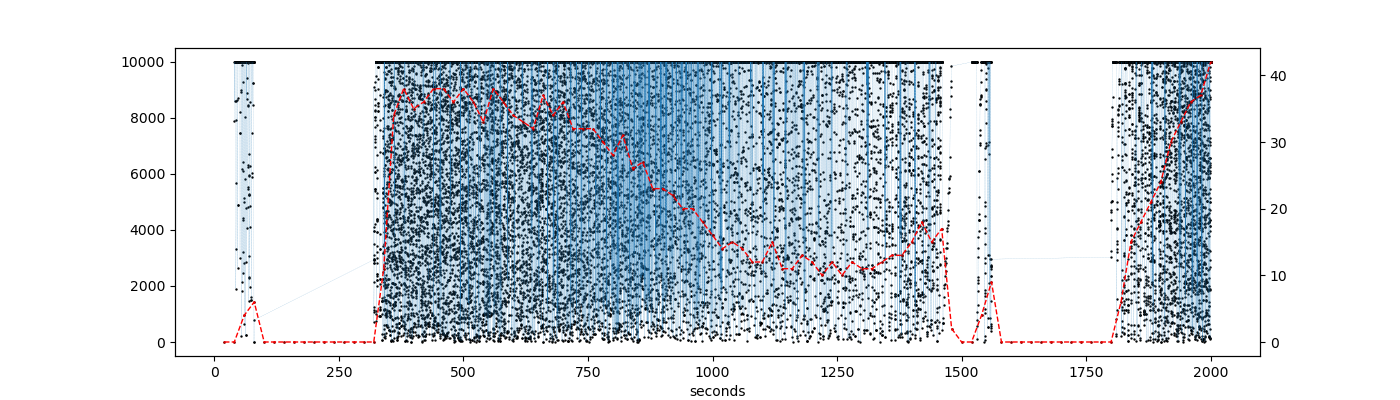

In [7]:
# Let's sum those rates
fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax2 = ax.twinx()
ax.set_xlabel('seconds')
ax.plot(timestamp,veto['stimestamp'][:total_cnt],ls='--',lw=.1)
ax.scatter(timestamp,veto['stimestamp'][:total_cnt],marker='o',s=.5,c='k')
ax2.plot(np.arange(*RANGE)*TIME + TIME,orbit['ratev'][RANGE[0]:RANGE[1]],ls='--',lw=1,c='r')
ax2.scatter(np.arange(*RANGE)*TIME + TIME,orbit['ratev'][RANGE[0]:RANGE[1]],marker='o',s=1,c='darkred')

(<Figure size 1500x400 with 1 Axes>,
 <AxesSubplot:title={'center':'Timestamps vs event number'}>)

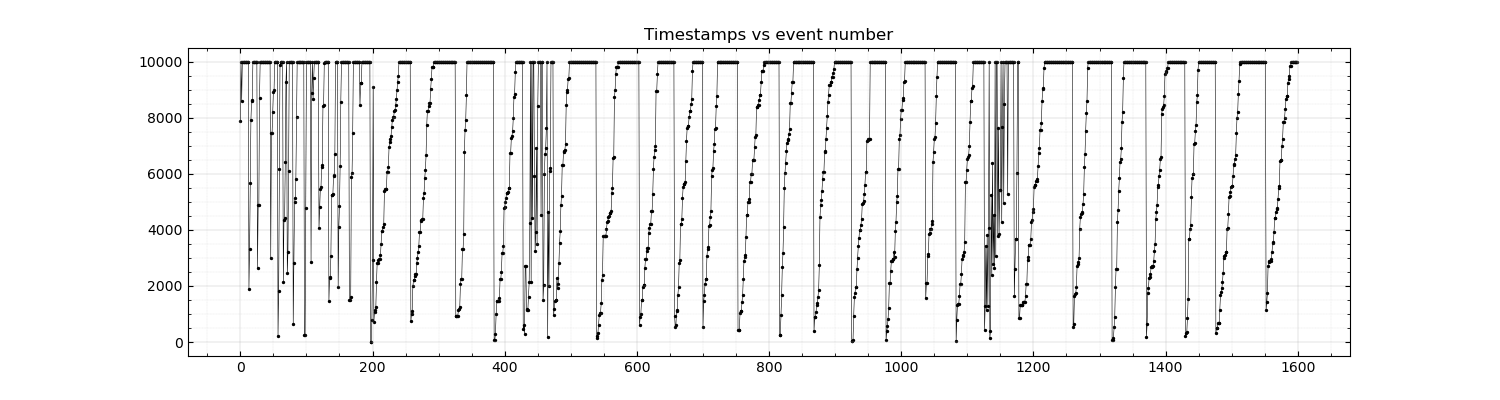

In [8]:
# Here is Some timestamps
rp.plot_timestamp(veto,rp.VETO_STRUCT,RANGE=(0,1600))

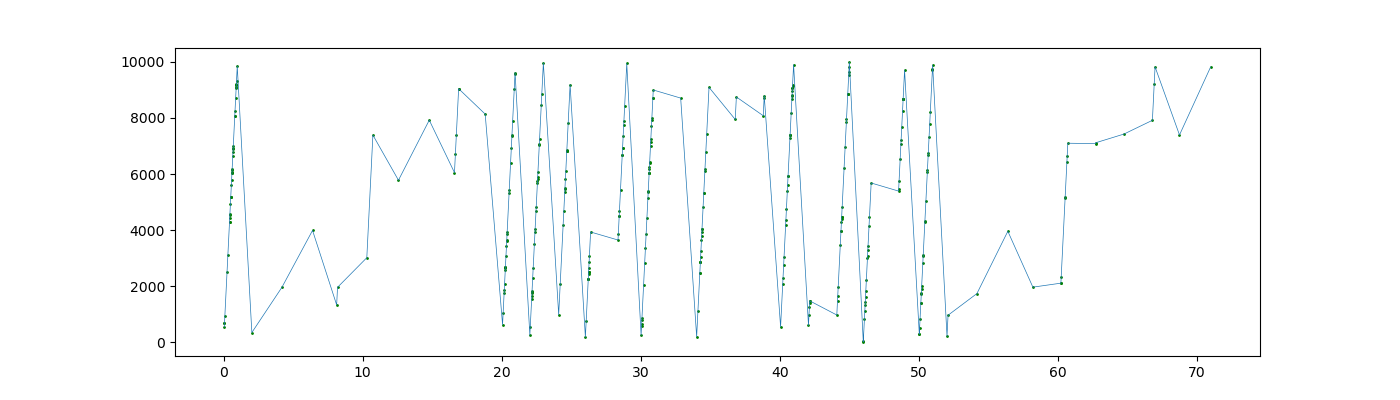

In [9]:
# To auditionally correct for the rest of the data we want to so using the stimestamp
# Correct based on FPGA counter
def correct_time_FPGA(data:dict,RIZE_TIME:int=1,CONST_TIME:int=1,TMAX:int=10000-1,RANGE=(0,1600)):
    # Find all the ramps
    # Array to store the beginning each ramp
    starting = []

    # Find all the starting points
    for i in range(RANGE[0],RANGE[1]-2):
        # Get the triplet
        A = data['stimestamp'][i]
        B = data['stimestamp'][i+1]
        
        # Examine cases
        if B-A < 0: starting.append(i+1)

    # Array to store the endings of each ramp
    ending = []

    # Find all the ending points
    for i in range(RANGE[0],RANGE[1]-2):
        # Get the triplet
        A = data['stimestamp'][i]
        B = data['stimestamp'][i+1]
        C = data['stimestamp'][i+2]

        # Examine cases
        if C-B < 0 and B-A != 0: 
            if B==TMAX: ending.append(i)
            else: ending.append(i+1)
        
        elif A == B and B != TMAX and C-B < 0: ending.append(i+1)

        elif C==B and B==TMAX and B-A > 0: ending.append(i)

    # Add the first point
    if starting[0] > ending[0]: starting.insert(0,RANGE[0])

    # Create the pairs of start and end points
    ramps = list(zip(starting,ending))

    # Now that we have all the ramps we assign one second to each ramp and we place the points accordingly
    curr_second = 0     # Current second
    timestamp   = []    # Timestamps
    valid_data  = []    # List to store the data on the rize or fall

    # For each ramp
    for ramp in ramps:
        # Take the elements of the ramp and append them to timestamp
        for i in range(ramp[0],ramp[1]+1):
            timestamp.append(curr_second+data['stimestamp'][i]*RIZE_TIME/(TMAX+1))
            valid_data.append(i)

        # Increase the timestamp
        curr_second+=RIZE_TIME+CONST_TIME
    
    return timestamp, valid_data #,starting, ending

# Apply this to the data
# Assume the parameters of the stimestamp saturation are as follows
RIZE_TIME   = 1         # In seconds 
CONST_TIME  = 1         # In seconds
TMAX        = 10000-1   # Maximum number of ticks per second
RANGE       = (2560, 3280)  # Range of timestamps to look at

timestamp_veto,valid_data = correct_time_FPGA(veto,RIZE_TIME=RIZE_TIME,CONST_TIME=CONST_TIME,TMAX=TMAX,RANGE=RANGE)

fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax.plot(timestamp_veto,veto['stimestamp'][valid_data],lw=0.5)
ax.scatter(timestamp_veto,veto['stimestamp'][valid_data],c='g',s=1)
# ax.scatter(ending,veto['stimestamp'][ending],c='r',s=1)


In [10]:
# fig = plt.figure(figsize=(14,4),dpi=100)
# ax  = fig.add_subplot(111)
# ax.plot(range(*RANGE),veto['stimestamp'][RANGE[0]:RANGE[1]],lw=0.5)
# ax.scatter(starting,veto['stimestamp'][starting],c='g',s=1)
# ax.scatter(ending,veto['stimestamp'][ending],c='r',s=1)

In [16]:
# Now putting everything together
def correct_time(data:dict,orbit:dict,TIME:int=20,RANGE_ORBIT=(0,100),RIZE_TIME:int=1,CONST_TIME:int=1,TMAX:int=10000-1):
    # First collect the timstamp based on the orbit data
    # Some variables
    total_cnt       = 0                     # Stores the total number of events
    processed_cnt   = 0                     # Stores the number of events processed
    current_time    = TIME*RANGE_ORBIT[0]   # The current time 
    timestamp       = []                    # New timestamp
    valid_events    = []                    # Stores the indices of the events that can be timestamped

    oops = 0
    # For each count in the orbit
    for count in orbit['ratev'][RANGE_ORBIT[0]:RANGE_ORBIT[1]]:
        # Get the next number of counts
        count = int(count*TIME)
        if count == 0:
            current_time += TIME
            continue

        # Now filter the events that can be placed in the timestamp and
        timestamp_veto, valid_data = correct_time_FPGA(data,RIZE_TIME=RIZE_TIME,CONST_TIME=CONST_TIME,TMAX=TMAX,RANGE=(processed_cnt,processed_cnt+count))

        # Add the new data on the timestamp
        for valid,time in zip(valid_data,timestamp_veto):
            timestamp.append(current_time + time)
            valid_events.append(valid)
            
        # Update the current time to the last used time
        if timestamp[-1] - current_time > TIME: 
            # print('Oops: ',oops,current_time,timestamp[-1])
            oops+=1
            current_time = timestamp[-1]
            # current_time += TIME
        else:
            current_time += TIME
        
        # Update the total count
        total_cnt       += len(valid_data)
        processed_cnt   += count

    print("Oops': ",oops/(RANGE_ORBIT[1]-RANGE_ORBIT[0]))

    # # remove the last element of the timestamp
    # timestamp = timestamp[:-1]

    # Fix the total number of entries we have
    total_cnt = int(total_cnt)

    return timestamp, total_cnt, valid_events

# Now appy this
TIME        = 20
RANGE       = (0,40)
RIZE_TIME   = 1      # In seconds 
CONST_TIME  = 1      # In seconds
TMAX        = 10000-1   # Maximum number of ticks per second

# Obtain the corrections
timestamp, total_cnt, valid_events = correct_time(veto,orbit,TIME=TIME,RANGE_ORBIT=RANGE,RIZE_TIME=RIZE_TIME,CONST_TIME=CONST_TIME,TMAX=TMAX)


Oops':  0.575


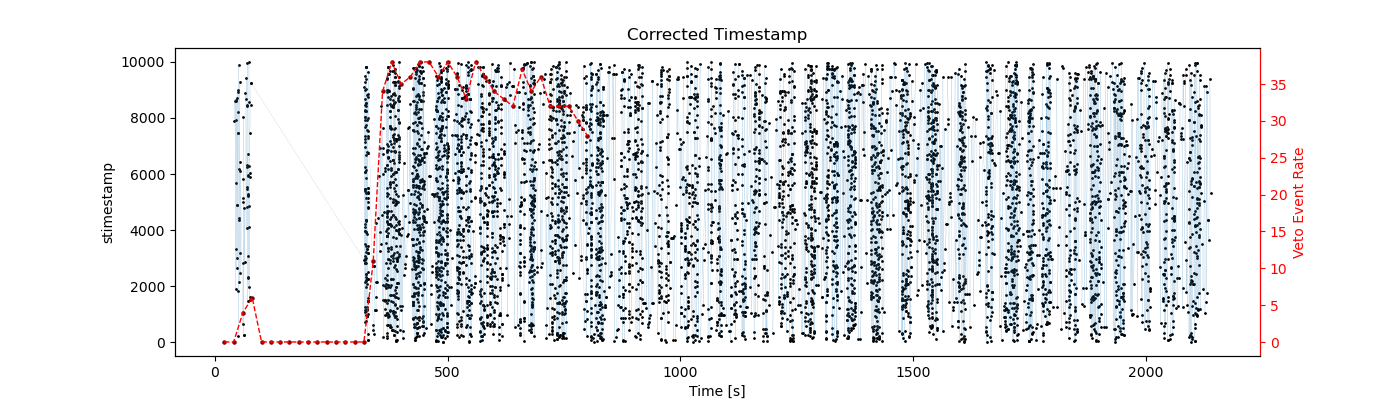

In [17]:
fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(timestamp,veto['stimestamp'][valid_events],lw=0.1,ls='--')
ax.scatter(timestamp,veto['stimestamp'][valid_events],c='k',s=1)
# ax.scatter(ending,veto['stimestamp'][ending],c='r',s=1)
ax2.plot(np.arange(*RANGE)*TIME + TIME,orbit['ratev'][RANGE[0]:RANGE[1]],ls='--',lw=1,c='r')
ax2.scatter(np.arange(*RANGE)*TIME + TIME,orbit['ratev'][RANGE[0]:RANGE[1]],marker='o',s=5,c='darkred')
ax.set_xlabel('Time [s]')
ax.set_ylabel('stimestamp')
ax.set_title('Corrected Timestamp')
ax2.set_ylabel('Veto Event Rate',c='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')

Text(0.5, 1.0, 'Event Number VS Timestamp')

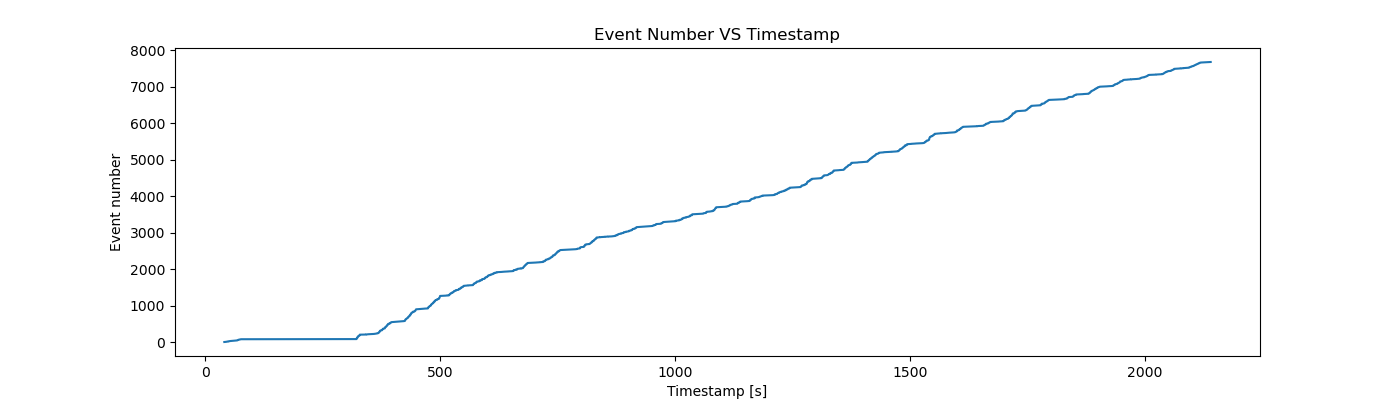

In [21]:
fig = plt.figure(figsize=(14,4),dpi=100)
ax  = fig.add_subplot(111)
ax.plot(timestamp,list(range(len(timestamp))))
ax.set_xlabel('Timestamp [s]')
ax.set_ylabel('Event number')
ax.set_title('Event Number VS Timestamp')